In [16]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5,amsgrad=True)
from time import time

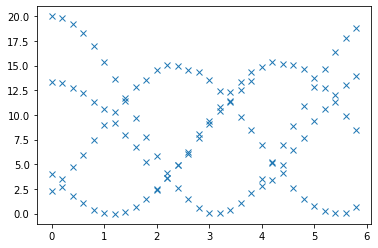

In [17]:
X = np.zeros([0,3])
Z = np.zeros([0,3])
Zlat = np.zeros([0,3])
y = np.zeros([0,1])
yreal = np.zeros([0,1])

#start & end positions, time start and end of each sample period, number of observations, number of inducing points in sensor and latent
samples = []
#path (pos,start time,obs)-(pos,end time)
samples.append({'ref':True,'path':[(0,0,30),(0,6,0)]})
samples.append({'ref':False,'path':[(0,0,10),(1,2,10),(0,4,10),(0,6,0)]})
samples.append({'ref':False,'path':[(1,0,30),(1,6)]})
#samples.append({'ref':False,'path':[(1,0,10),(2,2,10),(2,4,10)]})
samples.append({'ref':False,'path':[(2,0,30),(2,6)]})
S = len(samples) #number of sensors
sensorref = np.zeros([0,1])
for sensor,sample in enumerate(samples):
    Xnewt = np.zeros([0,1])
    Xnewp = np.zeros([0,1])
    for ps,pe in zip(sample['path'][:-1],sample['path'][1:]):
        Xnewt = np.r_[Xnewt,np.linspace(ps[1],pe[1],ps[2]+1)[:-1,None]]
        Xnewp = np.r_[Xnewp,np.full(ps[2],ps[0])[:,None]]
    
    sensorref = np.r_[sensorref,sample['ref']*np.ones([Xnewp.shape[0],1])]
    Xnew = np.c_[Xnewp,Xnewt,np.full(Xnewt.shape[0],sensor+1)]
    Znew = Xnew[::4,:]
    Znewlat = Xnew[::2,:]
    true = 10*(1+1*np.cos(Xnew[:,0:1]*2+Xnew[:,1:2]*1))
    if sample['ref']:
        ynew = true
    else:
        scaling = 1 + (-1**sensor + sensor*Xnew[:,1:2]/30 + np.sin(sensor*Xnew[:,1:2]/20)/30)/3
        ynew = true*(scaling)+np.random.randn(Xnew.shape[0],1)*0.1
    
    X = np.r_[X,Xnew]
    Z = np.r_[Z,Znew]
    Zlat = np.r_[Zlat,Znewlat]
    y = np.r_[y,ynew]
    yreal = np.r_[yreal,true]
latentX = X.copy()
latentX[:,-1]=0 #latent
X = np.r_[X,latentX]
Zlat[:,-1]=0
Z = np.r_[Z,Zlat]
plt.plot(X[0:int(len(X)/2),1],y,'x')

In [18]:
from tabulate import tabulate
print(tabulate(Z[::20,:],tablefmt="latex"))

\begin{tabular}{rrr}
\hline
 0 & 0   & 1 \\
 1 & 3.2 & 3 \\
 0 & 3.2 & 0 \\
 0 & 5.2 & 0 \\
 2 & 1.2 & 0 \\
\hline
\end{tabular}


In [19]:
X = tf.Variable(X,dtype=tf.float32)
Z = tf.Variable(Z,dtype=tf.float32)
y = tf.Variable(y,dtype=tf.float32)

In [20]:
def k(x1,x2):
    return np.exp(-(x1[1]-x2[1])**2/(2*5**2))

def klat(x1,x2):
    return np.exp(-(x1[1]-x2[1])**2/(2*1.0**2))

In [21]:
def K(X1,X2):
    try:
        X1 = X1.numpy()
        X2 = X2.numpy()
    except AttributeError:
        pass
    r = np.zeros([X1.shape[0],X2.shape[0]])
    for i1,x1 in enumerate(X1):
        for i2,x2 in enumerate(X2):
            if x1[2]==x2[2]==0: #if latent function...
                if x1[0]==x2[0]: #if in same place
                    r[i1,i2] = klat(x1,x2)
            if x1[2]==x2[2]!=0: #if scaling function
                r[i1,i2] = k(x1,x2)
    return tf.Variable(r,dtype=tf.float32)

In [22]:
np.sum(X[:,-1].numpy()==1)

30

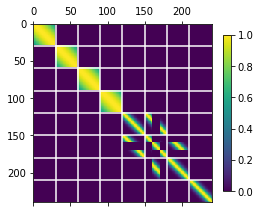

In [23]:
plt.matshow(K(X,X).numpy())
plt.colorbar(shrink=0.7)
plt.vlines(np.arange(0,X.shape[0],30),0,X.shape[0],'w')
plt.hlines(np.arange(0,X.shape[0],30),0,X.shape[0],'w')
plt.xlim([0,X.shape[0]])
plt.ylim([X.shape[0],0])
plt.savefig('democov.pdf')

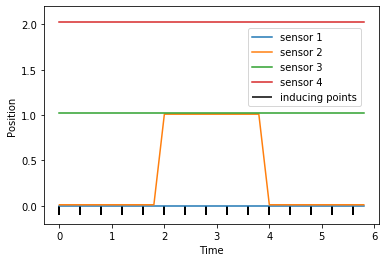

In [24]:
plt.figure(figsize=[6,4])
for s in range(0,S):
    sel = X.numpy()[:,2]==s+1
    plt.plot(X.numpy()[sel,1],s*0.01+X.numpy()[sel,0],'-',label="sensor %d" % int(s+1))

sel = X.numpy()[:,2]==0
#plt.plot(X.numpy()[sel,1],X.numpy()[sel,0],'xk')
plt.vlines(Z[:,1],-0.1,0,label='inducing points')
#plt.xlim([-1,12])
plt.ylabel('Position')
plt.xlabel('Time')
plt.ylim([-0.2,2.2])
plt.legend(loc=(0.61,0.54))
plt.savefig('routesofsensors.pdf')

In [25]:
#definition of q(u)
m = Z.shape[0]
mu = tf.Variable(0*tf.random.normal([m]))#, name='mu')
scale = tf.Variable(1*np.tril(1*np.random.randn(m, m)),dtype=tf.float32)#, name='scale')
###diag = tf.Variable(0*np.ones(m),dtype=tf.float32)

#parameters for p(u)
mu_u = tf.zeros([m],dtype=tf.float32)
cov_u = tf.Variable(K(Z,Z),dtype=tf.float32)

pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*0.01)
Kzz = K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01
Kxx = K(X,X)
Kxz = K(X,Z)
Kzx = K(Z,X)
N = int(X.shape[0]/2)

In [26]:
def combine_sensor_latent(sens,lat,sensorref):
    return lat * sensorref[:,0] + (1-sensorref[:,0])*(lat/(1+sens/3)) # * sensorref
    #return lat * sensorref[:,0] + (1-sensorref[:,0])*lat/tf.exp(sens/10) # * sensorref

In [27]:
#def getcov(scale,diag):
#    return scale @ tf.transpose(scale) + tf.linalg.diag(tf.exp(diag))

#def getcov(scale,diag):
#    return scale @ tf.transpose(scale) + tf.linalg.diag(tf.exp(diag)) + tf.eye(scale.shape[0])*1e-5
    
def getcov(scale,diag):
    """diag not used!"""
    return tf.linalg.band_part(scale, -1, 0) @ tf.transpose(tf.linalg.band_part(scale, -1, 0))


In [28]:
import time
alltimes = []
old_elbo_loss = -np.inf
optimizer.learning_rate = 0.05
likelihoodjitter = 1e-5
jitter = 1e-5
diag = None
for it in range(100000):
    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu,scale)        
        #qu = tfd.MultivariateNormalFullCovariance(mu,getcov(scale,diag))
        qf_mu = Kxz @ tf.linalg.solve(Kzz , mu[:,None])
        qf_cov = Kxx+tf.eye(Kxx.shape[0])*jitter - Kxz @ tf.linalg.solve(Kzz , Kzx) + Kxz @ tf.linalg.solve(Kzz,getcov(scale,diag)) @ tf.linalg.solve(Kzz ,Kzx)
        
        #columns are latent and sensor
        batched_mu = tf.transpose(tf.reshape(qf_mu,[2,N]))
        batched_cov = [[tf.linalg.diag_part(qf_cov[:N,:N]),tf.linalg.diag_part(qf_cov[N:,:N])],[tf.linalg.diag_part(qf_cov[:N,N:]),tf.linalg.diag_part(qf_cov[N:,N:])]]
        try:
            samps = tfd.MultivariateNormalFullCovariance(batched_mu,tf.transpose(batched_cov)+tf.eye(2)*jitter).sample(900)
        except tf.errors.InvalidArgumentError:
            print("j!",end="")
            jitter *= 10
            if jitter>10:
                break
            continue
        jitter = 1e-10   
        
        #pass (sensor,latent,sensorref)
        f = combine_sensor_latent(samps[:,:,0],samps[:,:,1],sensorref)
        
        lls = tfd.Normal(f,0.01).log_prob(y[:,0])
        #ell = tf.math.reduce_sum(tf.math.reduce_mean(lls,axis=0))
        ell = tf.math.reduce_sum(tfp.stats.percentile(tf.math.reduce_mean(tf.reshape(lls,[30,30,N]),axis=0),50.0,axis=0))
        #if it<400:
        elbo_loss = -ell+tfd.kl_divergence(qu,pu)
        #else:
        #   elbo_loss = -ell+tfd.kl_divergence(qu,pu)*(1-(it-400)/600)+tfd.kl_divergence(pu,qu)*((it-400)/600)
    
    try:
        if it<100:
            gradients = tape.gradient(elbo_loss, [mu])
            optimizer.apply_gradients(zip(gradients, [mu]))
        else:
            #gradients = tape.gradient(elbo_loss, [mu, scale,diag])
            #optimizer.apply_gradients(zip(gradients, [mu, scale,diag]))
            gradients = tape.gradient(elbo_loss, [mu, scale])
            optimizer.apply_gradients(zip(gradients, [mu, scale]))
    except tf.errors.InvalidArgumentError:
        print("Matrix non-invertible")
        jitter*=10
        break
    
    if elbo_loss<old_elbo_loss:
        optimizer.learning_rate=optimizer.learning_rate*1.01
    else:
        #print(optimizer.learning_rate.numpy())
        optimizer.learning_rate=optimizer.learning_rate/1.02
       #continue #try again
    if optimizer.learning_rate>0.05: optimizer.learning_rate=0.05
    if optimizer.learning_rate<0.01: optimizer.learning_rate=0.01
    #scale = tf.Variable(tf.linalg.band_part(scale, -1, 0))
    
    if it%20 == 0: print(it,elbo_loss.numpy(),optimizer.learning_rate.numpy(),"(",ell.numpy(),tfd.kl_divergence(qu,pu).numpy(),tfd.kl_divergence(pu,qu).numpy(),")")
    #if not np.any(np.linalg.eigvals(scale.numpy())<1e-6):
    #    print("uhoh")
    old_elbo_loss=elbo_loss

0 219133540.0 0.04901961 ( -219008200.0 125351.13 inf )
20 213322180.0 0.040627234 ( -213196800.0 125371.914 inf )


KeyboardInterrupt: 

In [29]:
lls

<tf.Tensor: id=28892, shape=(900, 120), dtype=float32, numpy=
array([[-2.884e+06, -2.561e+06, -1.002e+06, ..., -6.202e+07, -1.069e+05,
        -3.177e+05],
       [-1.756e+06, -2.888e+06, -2.222e+06, ..., -3.586e+02, -3.746e+01,
        -8.351e+07],
       [-1.136e+06, -1.548e+06, -2.080e+06, ..., -4.162e+05, -1.305e+05,
        -5.550e+06],
       ...,
       [-1.393e+06, -1.274e+06, -1.395e+06, ..., -6.102e+03, -5.432e+04,
        -4.630e+05],
       [-1.194e+06, -2.351e+06, -1.243e+06, ..., -5.777e+05, -1.529e+07,
        -1.759e+06],
       [-1.220e+06, -1.136e+06, -2.798e+06, ..., -7.854e+05, -2.432e+06,
        -5.455e+04]], dtype=float32)>

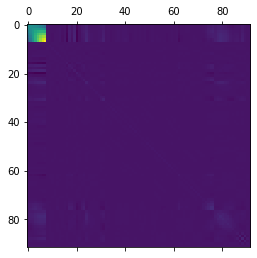

In [223]:
plt.matshow(getcov(scale,diag))

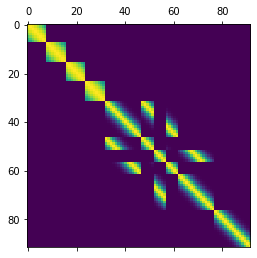

In [224]:
plt.matshow(Kzz.numpy())

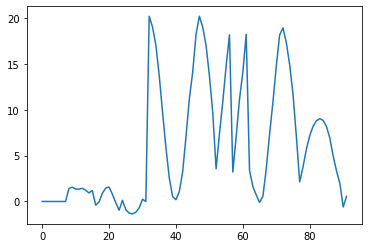

In [225]:
plt.plot(mu.numpy())

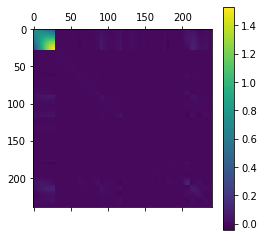

In [226]:
plt.matshow(qf_cov)
plt.colorbar()

(-1, 12)

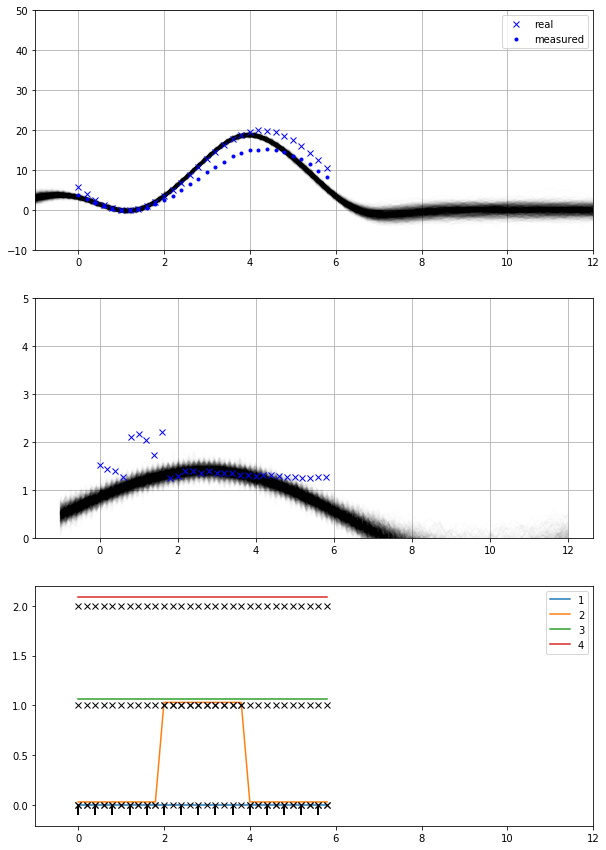

In [227]:
testpos = 1
testsensor = 0 #0=latent
plotsensor = 3

jitter = 1e-1

plt.figure(figsize=[10,15])
############################################################################
plt.subplot(3,1,1)
Xtest = np.linspace(-1,12,100)[:,None]
Xtest = tf.Variable(np.c_[testpos*np.ones(Xtest.shape[0]),Xtest,testsensor*np.ones(Xtest.shape[0])],dtype=tf.float32)
qf_mu = K(Xtest,Z) @ tf.linalg.solve(Kzz , mu[:,None])     
qf_cov = K(Xtest,Xtest) - K(Xtest,Z) @ tf.linalg.solve(Kzz , K(Z,Xtest)) + K(Xtest,Z)@ tf.linalg.solve(Kzz,getcov(scale,diag)) @ tf.linalg.solve(Kzz ,K(Z,Xtest))
qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*jitter)
samps = qf.sample([1000]).numpy()
plt.plot(Xtest[:,1],samps.T,'k-',alpha=0.01);

plt.xlim([-1,12])
tempX = X.numpy()[:N]
keep = (tempX[:,0]==testpos) & (tempX[:,2]==plotsensor)
plt.plot(tempX[keep,1],yreal[keep,0],'xb',label='real')
plt.plot(tempX[keep,1],y.numpy()[keep,0],'.b',label='measured')
plt.legend()
plt.vlines(Z[:,1],-15,-14)
plt.ylim([-10,50])
plt.grid()
##########################################################################
plt.subplot(3,1,2)
Xtest = np.linspace(-1,12,100)[:,None]
Xtest = tf.Variable(np.c_[testpos*np.ones(Xtest.shape[0]),Xtest,plotsensor*np.ones(Xtest.shape[0])],dtype=tf.float32)
qf_mu = K(Xtest,Z) @ tf.linalg.solve(Kzz , mu[:,None])
qf_cov = K(Xtest,Xtest) - K(Xtest,Z) @ tf.linalg.solve(Kzz , K(Z,Xtest)) + K(Xtest,Z)@ tf.linalg.solve(Kzz,getcov(scale,diag)) @ tf.linalg.solve(Kzz ,K(Z,Xtest))
qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*jitter)
samps = qf.sample([1000]).numpy().T
#plt.plot(Xtest[:,1],np.exp(-samps.T/10),'k-',alpha=0.2);
plt.plot(Xtest[:,1],1/combine_sensor_latent(samps,np.ones_like(samps),np.zeros([samps.shape[1],1])),'k-',alpha=0.01);
keep = (tempX[:,0]==testpos) & (tempX[:,2]==plotsensor)
plt.plot(tempX[keep,1],yreal[keep,0]/y.numpy()[keep,0],'xb')
#plt.plot(Xtest[:,1],(1+samps.T/50),'k-',alpha=0.2);
plt.ylim([0,5])
plt.grid()
##########################################################################
plt.subplot(3,1,3)
for s in range(0,S):
    sel = X.numpy()[:,2]==s+1
    plt.plot(X.numpy()[sel,1],s*0.03+X.numpy()[sel,0],'-',label=s+1)
plt.legend()
sel = X.numpy()[:,2]==0
plt.plot(X.numpy()[sel,1],X.numpy()[sel,0],'xk')
plt.vlines(Z[:,1],-0.1,0)
plt.xlim([-1,12])

In [228]:
diag

<tf.Variable 'Variable:0' shape=(92,) dtype=float32, numpy=
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=float32)>